In [1]:
import numpy as np, agama
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import astropy.units as u
import os

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

34.48275862068965


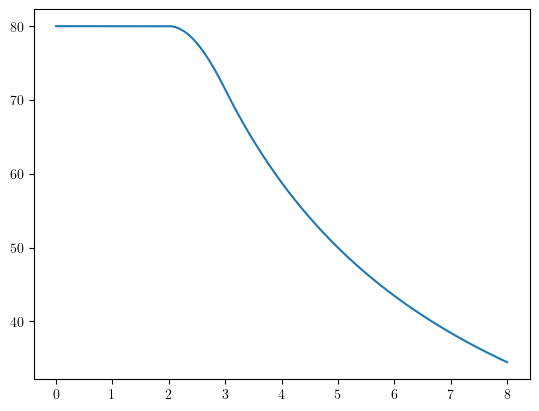

In [3]:
'''Create barred potential'''

# Function to calculate relative bar strength
def calc_bar_frac(t, t0, t1):
    xi = 2*(t - t0)/(t1 - t0) - 1
    bar_frac = np.clip(3/16*xi**5 - 5/8*xi**3 + 15/16*xi + 1/2, 0, 1)

    return bar_frac

from scipy.integrate import quad

def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters
t0 = 1  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 80
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# # Bar potential parameters
# t0 = 0     # Bar start time
# tf = -5   # End of simulation

# Omega_b_f = 35 # Final pattern speed (in km/s/kpc)
# # Omega_b_f = 30
# eta = 0.003

# Potential parameters
R_sun = 8.178
#vcirc_sun = 236.9
#M20 = 1.91

# Array of times for potential creation
bartime = np.linspace(0, tf, 1001)

Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

for i in range(len(bartime)):
    Omega_b[i] = calc_Omega_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)

phi_b -= phi_b[-1]

print(Omega_b[-1])

# Omega_b = Omega_b_f / (1 + eta*Omega_b_f*bartime)
# phi_b = 1/eta * np.log(1 + eta*Omega_b_f*bartime)
bar_frac = calc_bar_frac(bartime, t0, t1)

plt.figure()
plt.plot(bartime, Omega_b)
plt.show()
# plt.close()

# plt.plot(bartime, bar_frac)


In [4]:
'''Load potentials'''

agama_pot_path = 'agama_potentials/'

pot_axi_Hunter_path = 'MWPotentialHunter24_axi.ini'
pot_bar_Hunter_path = 'MWPotentialHunter24_full.ini'
pot_bar_Hunter_rot_path = 'MWPotentialHunter24_rotating.ini'
pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'
pot_nonaxi_path = 'MWPotentialHunter24_nonaxi.ini'

pot_axi_Hunter = agama.Potential(file=agama_pot_path+pot_axi_Hunter_path)
pot_bar_Hunter = agama.Potential(file=agama_pot_path+pot_bar_Hunter_path)
pot_bar_Hunter_rot = agama.Potential(file=agama_pot_path+pot_bar_Hunter_rot_path)
pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path)
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)
pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

pot_nonaxi = agama.Potential(pot_bar_baryon, pot_axi_baryon_neg)


34.48275862068965


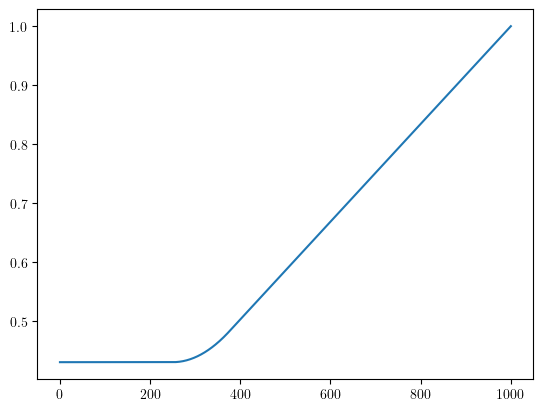

In [5]:
'''Make slowing barred potential'''

from scipy.optimize import fsolve

# First construct axisymmetric potential from baryonic Hunter24 potential + custom NFW
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)


# def make_potential(Omega_b_f, eta, t_f=-4):

#     bartime = np.linspace(tf, 0, 1001)

#     Omega_b = Omega_b_f / (1 + eta*Omega_b_f*bartime)
#     phi_b = 1/eta * np.log(1 + eta*Omega_b_f*bartime)
    
#     S = Omega_b_f/Omega_b
#     A = S
    
#     plt.plot(bartime, Omega_b)
#     plt.show()
#     plt.close()

#     plt.plot(bartime, S)
#     plt.show()
#     plt.close()

#     # Load full, scaled, rotated baryonic potential
#     pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
#     # And the axisymmetrised, scaled baryonic potential with equal but negative mass
#     pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

#     # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
#     # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
#     pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

#     return pot


# Then make full time-dependent potential with growing and slowing bar
def make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present):
    
    S = Omega_b_present/Omega_b
    A = bar_frac * S

    plt.plot(S)

    # Load full, scaled, rotated baryonic potential
    pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
    # And the axisymmetrised, scaled baryonic potential with equal but negative mass
    pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

    # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
    # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
    pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

    return pot

# Make custom potential
#pot_axi = make_pot(vcirc_sun, M20, pot_axi_baryon)

# Or use Hunter+24 potential
pot_axi = pot_axi_Hunter
pot_bar = pot_bar_Hunter

# Select pattern speed at which to match Hunter bar length
Omega_b_present = Omega_b[-1]

print(Omega_b_present)

pot_slow = make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present)



In [6]:
#%%

'''Import GC catalogue'''

import astropy.coordinates as coord

# Choose potential
agama_pot_path = 'agama_potentials/'#'/data/amd206/test/envs/py38_2/lib/python3.8/site-packages/agama/data/'
# pot = agama.Potential(agama_pot_path+'MWPotential2014_mod.ini')
# pot = agama.Potential(agama_pot_path+'Portail17_axi.ini')

GC_catalogue = np.loadtxt(datapath+'GC_catalogue.txt', dtype=str)

GC_names = GC_catalogue[:,0]

ra_GC = GC_catalogue[:,1].astype(float)
dec_GC = GC_catalogue[:,2].astype(float)
distance_GC = GC_catalogue[:,3].astype(float)
pmra_GC = GC_catalogue[:,9].astype(float)
pmdec_GC = GC_catalogue[:,10].astype(float)
vlos_GC = GC_catalogue[:,5].astype(float)

# Retrieve uncertainties for GCs
disterr = GC_catalogue[:,4].astype(float)
vloserr = GC_catalogue[:,6].astype(float)
pmraerr = GC_catalogue[:,12].astype(float)
pmdecerr = GC_catalogue[:,13].astype(float)

galcen_v_sun = np.array([11.1, 247.4, 7.25])*u.km/u.s

# galcen_v_sun = np.array([11.1, 250.24, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

coords_GC = coord.SkyCoord(ra=ra_GC*u.deg, dec=dec_GC*u.deg, distance=distance_GC*u.kpc, pm_ra_cosdec=pmra_GC*u.mas/u.yr, pm_dec=pmdec_GC*u.mas/u.yr, radial_velocity=vlos_GC*u.km/u.s)

# galcen_v_sun = np.array([11.1, 250.24, 7.25])*u.km/u.s#np.array([9.3, 251.5, 8.59])*u.km/u.s#(12.9, 245.6, 7.78)

coords_GC = coords_GC.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_GC = np.array([coords_GC.x.value, coords_GC.y.value, coords_GC.z.value, coords_GC.v_x.value, coords_GC.v_y.value, coords_GC.v_z.value]).T

# Convert to coordinate system where Sun is at x=8kpc, Galactic rotation in +y direction
ic_GC = ic_GC*np.array([-1, 1, 1, -1, 1, 1])

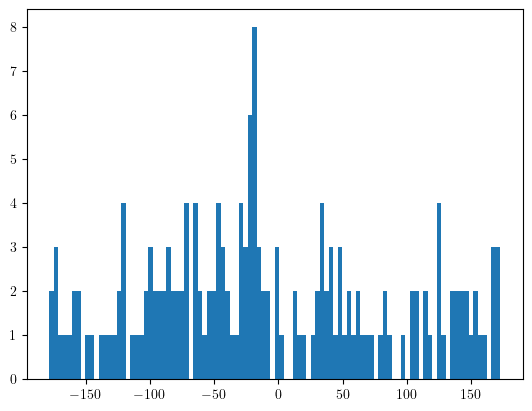

In [7]:
#%%

'''Calculate GC quantities'''

coords_GC_gal = coords_GC.transform_to('galactic')

l_GC = coords_GC_gal.l.value
l_GC = (l_GC + 180)%360 - 180
b_GC = coords_GC_gal.b.value


bar_angle = 30 * np.pi/180

phi_GC = (np.arctan2(ic_GC[:,1], ic_GC[:,0]) - bar_angle + np.pi) % (2 * np.pi) - np.pi

plt.hist(phi_GC*180/np.pi, bins=100)
plt.show()
plt.close()

r_GC = np.linalg.norm(ic_GC[:,0:3], axis=1)
R_GC = np.linalg.norm(ic_GC[:,0:2], axis=1)

R_hat = ic_GC[:,0:3] * [1, 1, 0] / R_GC[:,None]
vR_GC = (ic_GC[:,3:6] * R_hat).sum(axis=1)
vphi_GC = np.linalg.norm(ic_GC[:,3:6] - vR_GC[:,None]*R_hat - ic_GC[:,3:6]*[0,0,1], axis=-1)

r_hat = ic_GC[:,0:3] / r_GC[:,None]
vr_GC = (ic_GC[:,3:6] * r_hat).sum(axis=1)

# Rotate GCs into coordinate system with x-axis along bar's major axis
rot_mat = np.array([[np.cos(bar_angle), np.sin(bar_angle), 0], [-np.sin(bar_angle), np.cos(bar_angle), 0], [0, 0, 1]])

pos_GC = np.einsum('ij,kj->ki', rot_mat, ic_GC[:,0:3])
vel_GC = np.einsum('ij,kj->ki', rot_mat, ic_GC[:,3:6])

ic_GC = np.hstack((pos_GC, vel_GC))


# Calculate energy
E_GC = 0.5 * (ic_GC[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic_GC[:,0:3])

# Calculate angular momentum
L_GC = np.cross(ic_GC[:,0:3], ic_GC[:,3:6], axis=1)

# z-component and Lperp
Lz_GC = L_GC[:,2]
Lperp_GC = np.linalg.norm(L_GC[:,0:2], axis=1)

# Magnitude

L_mag_GC = np.linalg.norm(L_GC, axis=-1)


# '''Calculate actions'''

# af = agama.ActionFinder(pot)
# act_GC, ang_GC, freq_GC = af(ic_GC, angles=True)

In [8]:
'''Load GC masses'''

GC_struc_catalogue = np.loadtxt(datapath+'GC_struc_catalogue.txt', skiprows=3, dtype=str, usecols=[0,9])

GC_masses = GC_struc_catalogue[:,1].astype(float)

print(GC_struc_catalogue)


[['NGC_104' '8.53e+05']
 ['NGC_288' '9.62e+04']
 ['NGC_362' '2.52e+05']
 ['Whiting_1' '1.37e+03']
 ['NGC_1261' '1.72e+05']
 ['Pal_1' '9.26e+02']
 ['AM_1' '1.96e+04']
 ['Eridanus' '9.29e+03']
 ['Pal_2' '2.20e+05']
 ['NGC_1851' '2.83e+05']
 ['NGC_1904' '1.81e+05']
 ['NGC_2298' '4.98e+04']
 ['NGC_2419' '7.83e+05']
 ['Pyxis' '3.22e+04']
 ['NGC_2808' '7.91e+05']
 ['E_3' '2.56e+03']
 ['Pal_3' '1.85e+04']
 ['NGC_3201' '1.93e+05']
 ['Pal_4' '1.53e+04']
 ['Crater' '1.21e+04']
 ['NGC_4147' '4.51e+04']
 ['NGC_4372' '1.89e+05']
 ['Rup_106' '3.40e+04']
 ['NGC_4590' '1.28e+05']
 ['BH_140' '6.12e+04']
 ['NGC_4833' '1.86e+05']
 ['NGC_5024' '5.02e+05']
 ['NGC_5053' '6.28e+04']
 ['NGC_5139' '3.94e+06']
 ['NGC_5272' '4.09e+05']
 ['NGC_5286' '4.24e+05']
 ['AM_4' '7.46e+02']
 ['NGC_5466' '5.61e+04']
 ['NGC_5634' '2.47e+05']
 ['NGC_5694' '2.69e+05']
 ['IC_4499' '1.50e+05']
 ['NGC_5824' '7.46e+05']
 ['Pal_5' '1.34e+04']
 ['NGC_5897' '1.67e+05']
 ['NGC_5904' '3.92e+05']
 ['NGC_5927' '2.93e+05']
 ['NGC_5946' '

sID name nstar       rperi               rapo               ecc                 etot                lx                ly                  lz               lperp              lmax               circlz      
--- ---- ----- ------------------ ------------------ ------------------ -------------------- ---------------- ------------------ ------------------- ----------------- ------------------ -------------------
1.0 C-20    29 23.485256609097632 144.44760103008662 0.7203018284896052 -0.04020841033763155 7.66518678288009 1.9555200905134915 -3.5641710081506695 7.910698277702261 15.961329593562922 0.22330038279443032
956077.6287794535
977.7922216807891


(-3.0, 0.0)

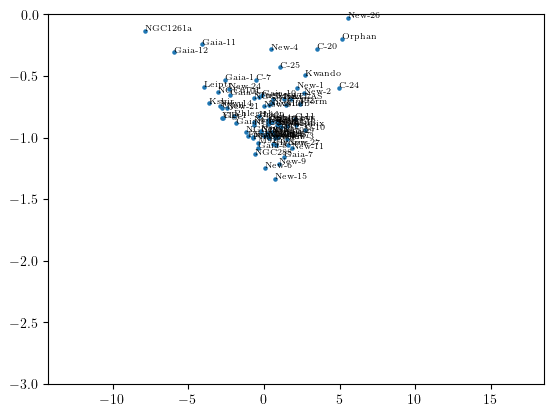

In [ ]:
'''Load stream orbit data'''

from astropy.io import fits
from astropy.table import Table

hdu = fits.open(datapath+'summary_stream_orbits.fits', memmap=True)
t = Table.read(hdu)

print(t[0])

pot_PW22 = agama.Potential(agama_pot_path+'PriceWhelan22.ini')

E_shift = pot_axi.potential([8,0,0]) - pot_PW22.potential([8,0,0])

E_conversion = ((u.kpc/u.Myr)**2 / (u.km/u.s)**2).to(u.dimensionless_unscaled)
L_conversion = ((u.kpc**2 / u.Myr) / (u.kpc*u.km/u.s)).to(u.dimensionless_unscaled)

print(E_conversion)
print(L_conversion)

E_stream = np.array(t['etot']) * E_conversion + E_shift
Lz_stream = -np.array(t['lz']) * L_conversion
Lx_stream = np.array(t['lx'])  * L_conversion
Ly_stream = np.array(t['ly']) * L_conversion

Lperp_stream = np.array(t['lperp']) * L_conversion

L_mag_stream = (Lx_stream**2 + Ly_stream**2 + Lz_stream**2)**0.5

apo_stream = np.array(t['rapo'])
peri_stream = np.array(t['rperi'])
ecc_stream = np.array(t['ecc'])

name_stream = t['name']
nstar = t['nstar']



# Plot Lz and E
plt.scatter(Lz_stream/1e3, E_stream/1e5, c='tab:blue', s=5)

for i in range(len(name_stream)):
    if E_stream[i]<0:
        plt.text(Lz_stream[i]/1e3, E_stream[i]/1e5, name_stream[i], fontsize=6)

plt.ylim(-3, 0)


In [10]:
'''Integrate orbits of selected GCs in rotating barred potential'''

def test_part_sim(ic, pot, time, trajsize=2, Omega=0, timestart=0):
    
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega, time=time, trajsize=trajsize, timestart=timestart)
    
    ts = o[:,0][0]
    trajs = np.stack(o[:,1]).transpose((1,0,2))

    return trajs, ts

In [ ]:
'''Generate a stellar stream from a GC'''
'''lambda_source and strip_rate must be defined before calling the function'''

from astropy.constants import G

def lagrange_cloud_strip(fc, potential, trajsize=1001, Omega=0, rewind=True):#int(np.round((Tfinal-Tbegin)/Tstep)+1)

    # Integrate orbit of progenitor
    
    if rewind == True:
        prog_orbit = agama.orbit(ic=fc, potential=potential, timestart=tf, time=-tf, trajsize=trajsize, Omega=Omega)
        
        times = np.flip(prog_orbit[0])
        trajsize = len(times)
        prog_traj = np.flip(prog_orbit[1], axis=0)
        prog_traj_array = np.hstack((np.array([times]).T, prog_traj))
    
    else:
        prog_orbit = agama.orbit(ic=fc, potential=potential, timestart=0, time=tf, trajsize=trajsize, Omega=Omega)
        
        times = prog_orbit[0]
        trajsize = len(times)
        prog_traj = prog_orbit[1]
        prog_traj_array = np.hstack((np.array([times]).T, prog_traj))

    #print(prog_traj_array.shape)
    
    # np.savetxt('prog_traj_'+str(os.getpid())+'.txt', prog_traj_array[:, 0:4])
    
    # Construct potential of progenitor and combine with total potential
    # potprog = agama.Potential(type='Plummer', mass=M_s, scaleRadius=a_s, center=prog_traj_array)#'prog_traj_'+str(os.getpid())+'.txt')
    # pottot_prog = agama.Potential(potential, potprog)
    
    # Calculate angular speed of progenitor (in units of km/s/kpc)
    r_prog = np.linalg.norm(prog_traj[:,0:3], axis=1)
    L_prog = np.linalg.norm(np.cross(prog_traj[:,0:3], prog_traj[:,3:6]), axis=1)
    Omega_prog = L_prog / r_prog**2
    
    # Calculate 2nd derivative of external potential
    force, deriv = potential.forceDeriv(prog_traj[:,0:3], t=times)
    
    # Calculate Hessian matrix
    Hessian = np.zeros((trajsize, 3, 3))
    Hessian[:, 0, :] = -np.array([deriv[:, 0], deriv[:, 3], deriv[:, 5]]).T
    Hessian[:, 1, :] = -np.array([deriv[:, 3], deriv[:, 1], deriv[:, 4]]).T
    Hessian[:, 2, :] = -np.array([deriv[:, 5], deriv[:, 4], deriv[:, 2]]).T
    
    r_hat = prog_traj[:, 0:3] / r_prog[:,None]
    d2Phi_d2r = np.einsum('ki,kij,kj->k', r_hat, Hessian, r_hat)
    
    r_t_max = 1 # Cap on tidal radius (used to replace nans)
    
    r_t = np.nan_to_num( (((G * M_s / (Omega_prog**2 - d2Phi_d2r))*u.Msun/(u.km/u.s/u.kpc)**2)**(1/3)).to(u.kpc).value, nan=r_t_max)
    
    r_t = np.minimum(r_t, r_t_max)    # Limit r_t to chosen value
    
    source_coords_in = prog_traj[:, 0:3] - lambda_source * r_t[:, None] * r_hat
    source_coords_out = prog_traj[:, 0:3] + lambda_source * r_t[:, None] * r_hat
    
    prog_velocity_r = np.sum(prog_traj[:, 3:6]*r_hat, axis=1)
    prog_velocity_tan = prog_traj[:, 3:6] - prog_velocity_r[:, None] * r_hat
    
    source_velocity_tan_in = prog_velocity_tan * (1 - 0.5 * r_t / r_prog)[:, None]
    source_velocity_tan_out = prog_velocity_tan * (1 + 0.5 * r_t / r_prog)[:, None]
    
    source_velocity_in = prog_velocity_r[:, None] * r_hat + source_velocity_tan_in
    source_velocity_out = prog_velocity_r[:, None] * r_hat + source_velocity_tan_out
    
    source_coords = np.zeros((len(source_coords_in)*2, 3))
    source_coords[::2] = source_coords_in
    source_coords[1::2] = source_coords_out
    
    source_velocity = np.zeros((len(source_velocity_in)*2, 3))
    source_velocity[::2] = source_velocity_in
    source_velocity[1::2] = source_velocity_out
    
    ic_source_coords = np.repeat(source_coords, strip_rate/2, axis=0)
    ic_source_velocities = np.repeat(source_velocity, strip_rate/2, axis=0)
    
    np.random.seed(0)
    ic = np.hstack((ic_source_coords, ic_source_velocities)) + np.hstack((np.zeros((trajsize*strip_rate, 3)), np.random.randn(trajsize*strip_rate, 3)*sigma_s))
    
    start_times = np.repeat(times, strip_rate)
    
    trajsizes = np.repeat(np.arange(trajsize, 0, -1), strip_rate)

    result = agama.orbit(ic=ic, potential=potential, timestart=start_times, time=tf-start_times, trajsize=trajsizes, Omega=Omega)[:-strip_rate]
    
    trajs = np.zeros((trajsize, len(result), 6))
    for part_index in range(len(result)):
        trajsize_part = trajsizes[part_index]
        traj_part = trajs[:, part_index, :]
        
        traj_part[0:-trajsize_part, :] = prog_traj[0:-trajsize_part]
        traj_part[-trajsize_part:, :] = result[:, 1][part_index]
        
        # trajs[0:-trajsizes[part_index], part_index, :] = prog_traj[0:-trajsizes[part_index]]
        # trajs[-trajsizes[part_index]:, part_index, :] = result[:, 1][part_index]
    
    #print('5 = ', time.process_time()-start_prog)
    
    return trajs, prog_traj, r_t

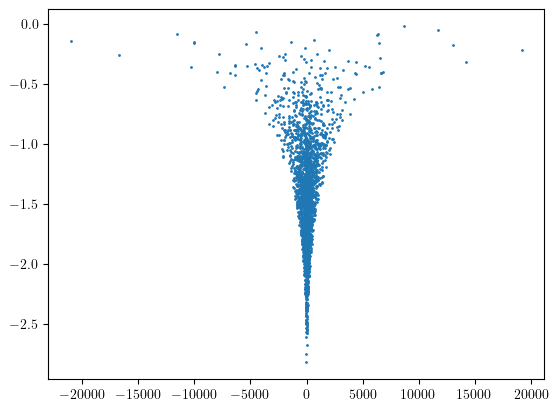

2000


In [ ]:

'''Generate ICs from smooth GC distribution function'''

# Number of progenitors (200 or 2000)
Nbody = 2000

# GC-like DF
df_GC = agama.DistributionFunction(type='DoublePowerLaw', norm=1e9, slopeOut=5.03, slopeIn=1.23, steepness=1.08, coefJrOut=0.65, coefJzOut=1.32, coefJrIn=1.86, coefJzIn=1.01, J0=10**3.08, rotFrac=0)

ic_smooth, mass = agama.GalaxyModel(pot_axi, df_GC).sample(Nbody)

# ic_smooth = ic_GC

# Calculate E and Lz
E_smooth = 0.5 * (ic_smooth[:,3:6]**2).sum(axis=1) + pot_axi.potential(ic_smooth[:,0:3])
Lz_smooth = np.cross(ic_smooth[:,0:3], ic_smooth[:,3:6])[:,2]

plt.scatter(Lz_smooth, E_smooth/1e5, s=1)

plt.show()
plt.close()


In [534]:
'''Generate tails of streams in axisymmetric, steadily rotating barred, and decelerating barred potentials'''

from matplotlib.patches import Circle

# Simulation paramters
M_s = 1e5 #7.79e5
a_s = 1e-3 #4.32e-3
sigma_s = 1
lambda_source = 1
strip_rate = 2
trajsize = 81 #1001

# bartime = np.linspace(t_f, 0, trajsize)

# Initial conditions
ic = ic_smooth
N_GC = len(ic)

print(N_GC)

trajs_axi_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))
trajs_bar_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))
trajs_slow_array = np.zeros((N_GC, trajsize, strip_rate*(trajsize-1), 6))

prog_traj_axi_array = np.zeros((N_GC, trajsize, 6))
prog_traj_bar_array = np.zeros((N_GC, trajsize, 6))
prog_traj_slow_array = np.zeros((N_GC, trajsize, 6))

for i in range(N_GC):#len(ic_GC)):
    # fc = ic_GC[GC_names_mod == '47 Tuc'][0]
    if E_smooth[i] < 0:
        fc = ic[i]
        trajs_axi, prog_traj_axi, r_t_axi = lagrange_cloud_strip(fc, potential=pot_axi, trajsize=trajsize, rewind=False)
        trajs_bar, prog_traj_bar, r_t_bar = lagrange_cloud_strip(fc, potential=pot_bar, trajsize=trajsize, Omega=Omega_b_present)
        trajs_slow, prog_traj_slow, r_t_slow = lagrange_cloud_strip(fc, potential=pot_slow, trajsize=trajsize, rewind=False)

        trajs_axi_array[i] = trajs_axi
        trajs_bar_array[i] = trajs_bar
        trajs_slow_array[i] = trajs_slow

        prog_traj_axi_array[i] = prog_traj_axi
        prog_traj_bar_array[i] = prog_traj_bar
        prog_traj_slow_array[i] = prog_traj_slow
        

2000
162 orbits complete (2189 orbits/s)
162 orbits complete (1200 orbits/s)
162 orbits complete (447.5 orbits/s)
162 orbits complete (1073 orbits/s)
162 orbits complete (506.2 orbits/s)
162 orbits complete (218.3 orbits/s)
162 orbits complete (1688 orbits/s)
162 orbits complete (861.7 orbits/s)
162 orbits complete (375 orbits/s)
162 orbits complete (710.5 orbits/s)
162 orbits complete (306.2 orbits/s)
162 orbits complete (122.2 orbits/s)
162 orbits complete (3240 orbits/s)
162 orbits complete (1473 orbits/s)
162 orbits complete (613.6 orbits/s)
162 orbits complete (6000 orbits/s)
162 orbits complete (2842 orbits/s)
162 orbits complete (1157 orbits/s)
162 orbits complete (2793 orbits/s)
162 orbits complete (1339 orbits/s)
162 orbits complete (595.6 orbits/s)
162 orbits complete (405 orbits/s)
162 orbits complete (236.2 orbits/s)
162 orbits complete (92.78 orbits/s)
162 orbits complete (620.7 orbits/s)
162 orbits complete (257.1 orbits/s)
162 orbits complete (183.5 orbits/s)
162 orbits 

In [535]:
'''Save simulation'''

np.save(simpath+'trajs_axi_array_hires', trajs_axi_array)
np.save(simpath+'prog_traj_axi_array_hires', prog_traj_axi_array)

np.save(simpath+'trajs_bar_array_hires', trajs_bar_array)
np.save(simpath+'prog_traj_bar_array_hires', prog_traj_bar_array)

np.save(simpath+'trajs_slow_array_hires', trajs_slow_array)
np.save(simpath+'prog_traj_slow_array_hires', prog_traj_slow_array)

In [11]:
'''Load simulations'''
'''COMMENT OUT BLOCKS AS APPROPRIATE'''

# Select either simulations with 200 progenitors and 1600 stars each
trajs_axi_array = np.load(simpath+'trajs_axi_array.npy')
prog_traj_axi_array = np.load(simpath+'prog_traj_axi_array.npy')

trajs_bar_array = np.load(simpath+'trajs_bar_array.npy')
prog_traj_bar_array = np.load(simpath+'prog_traj_bar_array.npy')

trajs_slow_array = np.load(simpath+'trajs_slow_array.npy')
prog_traj_slow_array = np.load(simpath+'prog_traj_slow_array.npy')

# Or 2000 progenitors and 160 stars each
# trajs_axi_array = np.load(simpath+'trajs_axi_array_hires.npy')
# prog_traj_axi_array = np.load(simpath+'prog_traj_axi_array_hires.npy')

# trajs_bar_array = np.load(simpath+'trajs_bar_array_hires.npy')
# prog_traj_bar_array = np.load(simpath+'prog_traj_bar_array_hires.npy')

# trajs_slow_array = np.load(simpath+'trajs_slow_array_hires.npy')
# prog_traj_slow_array = np.load(simpath+'prog_traj_slow_array_hires.npy')

In [ ]:
'''Array of stripping times'''

trajsize = 81
strip_rate = 2

ts = np.linspace(0, tf, trajsize)

strip_time = np.repeat(ts[:-1], strip_rate)


[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.4 0.4 0.5 0.5 0.6 0.6 0.7 0.7 0.8 0.8
 0.9 0.9 1.  1.  1.1 1.1 1.2 1.2 1.3 1.3 1.4 1.4 1.5 1.5 1.6 1.6 1.7 1.7
 1.8 1.8 1.9 1.9 2.  2.  2.1 2.1 2.2 2.2 2.3 2.3 2.4 2.4 2.5 2.5 2.6 2.6
 2.7 2.7 2.8 2.8 2.9 2.9 3.  3.  3.1 3.1 3.2 3.2 3.3 3.3 3.4 3.4 3.5 3.5
 3.6 3.6 3.7 3.7 3.8 3.8 3.9 3.9 4.  4.  4.1 4.1 4.2 4.2 4.3 4.3 4.4 4.4
 4.5 4.5 4.6 4.6 4.7 4.7 4.8 4.8 4.9 4.9 5.  5.  5.1 5.1 5.2 5.2 5.3 5.3
 5.4 5.4 5.5 5.5 5.6 5.6 5.7 5.7 5.8 5.8 5.9 5.9 6.  6.  6.1 6.1 6.2 6.2
 6.3 6.3 6.4 6.4 6.5 6.5 6.6 6.6 6.7 6.7 6.8 6.8 6.9 6.9 7.  7.  7.1 7.1
 7.2 7.2 7.3 7.3 7.4 7.4 7.5 7.5 7.6 7.6 7.7 7.7 7.8 7.8 7.9 7.9]


In [13]:
'''Cut simulation to first and last snapshots'''

trajs_axi_array = trajs_axi_array[:,[0,-1]]
prog_traj_axi_array = prog_traj_axi_array[:,[0,-1]]

trajs_bar_array = trajs_bar_array[:,[0,-1]]
prog_traj_bar_array = prog_traj_bar_array[:,[0,-1]]

trajs_slow_array = trajs_slow_array[:,[0,-1]]
prog_traj_slow_array = prog_traj_slow_array[:,[0,-1]]

print(trajs_slow_array.shape)

(200, 2, 1600, 6)


In [ ]:
'''Calculate energy and angular momentum'''

L_prog = np.cross(prog_traj_slow_array[:,:,0:3], prog_traj_slow_array[:,:,3:6])
Lz_prog = L_prog[:,:,2]

def calc_E_act_ang_freq(trajs_array, pot_axi=pot_axi):
    E_pot = np.zeros(trajs_array.shape[:-1])
    # E_pot_prog = np.zeros(prog_traj_slow_array.shape[0:2])
    act = np.zeros(trajs_array.shape[:-1]+(3,))
    ang = np.zeros(trajs_array.shape[:-1]+(3,))
    freq = np.zeros(trajs_array.shape[:-1]+(3,))
    # act_prog = np.zeros(L_prog.shape)
    # ang_prog = np.zeros(L_prog.shape)
    # freq_prog = np.zeros(L_prog.shape)
    af = agama.ActionFinder(pot_axi)

    for i in range(trajs_array.shape[0]):
        for j in range(trajs_array.shape[1]):
            E_pot[i,j] = pot_axi.potential(trajs_array[i,j,...,0:3])
            act[i,j], ang[i,j], freq[i,j] = af(trajs_array[i,j], angles=True)
        # E_pot_prog[i] = pot_axi.potential(prog_traj_slow_array[i,:,0:3])
        # act_prog[i], ang_prog[i], freq_prog[i] = af(prog_traj_slow_array[i], angles=True)

    E = 0.5 * (trajs_array[...,3:6]**2).sum(axis=-1) + E_pot

    return E, act, ang, freq

E_axi, act_axi, ang_axi, freq_axi = calc_E_act_ang_freq(trajs_axi_array, pot_axi)
E_bar, act_bar, ang_bar, freq_bar = calc_E_act_ang_freq(trajs_bar_array, pot_axi)
E_slow, act_slow, ang_slow, freq_slow = calc_E_act_ang_freq(trajs_slow_array, pot_axi)

E_prog_axi, act_prog_axi, ang_prog_axi, freq_prog_axi = calc_E_act_ang_freq(prog_traj_axi_array, pot_axi)
E_prog_bar, act_prog_bar, ang_prog_bar, freq_prog_bar = calc_E_act_ang_freq(prog_traj_bar_array, pot_axi)
E_prog_slow, act_prog_slow, ang_prog_slow, freq_prog_slow = calc_E_act_ang_freq(prog_traj_slow_array, pot_axi)

L_axi = np.cross(trajs_axi_array[:,:,:,0:3], trajs_axi_array[:,:,:,3:6])
L_bar = np.cross(trajs_bar_array[:,:,:,0:3], trajs_bar_array[:,:,:,3:6])
L_slow = np.cross(trajs_slow_array[:,:,:,0:3], trajs_slow_array[:,:,:,3:6])

Lz_axi = act_axi[...,2]
Lz_bar = act_bar[...,2]
Lz_slow = act_slow[...,2]

Lperp_axi = np.linalg.norm(L_axi[:,:,:,0:2], axis=-1)
Lperp_bar = np.linalg.norm(L_bar[:,:,:,0:2], axis=-1)
Lperp_slow = np.linalg.norm(L_slow[:,:,:,0:2], axis=-1)

L_prog_axi = np.cross(prog_traj_axi_array[:,:,0:3], prog_traj_axi_array[:,:,3:6])
Lperp_prog_axi = np.linalg.norm(L_prog_axi[:,:,0:2], axis=-1)

Lz_prog_axi = act_prog_axi[...,2]
Lz_prog_bar = act_prog_bar[...,2]
Lz_prog_slow = act_prog_slow[...,2]

HJ_axi = E_axi - Omega_b[None,[0,-1],None] * Lz_axi
HJ_bar = E_bar - Omega_b[None,[0,-1],None] * Lz_bar
HJ_slow = E_slow - Omega_b[None,[0,-1],None] * Lz_slow


In [19]:
'''Cut to only show streams with energies below certain level (avoids problems with potential at large radius)'''

prog_cut = E_prog_axi[:,0] < -0.25e5

(200, 2, 3)
(200, 2)


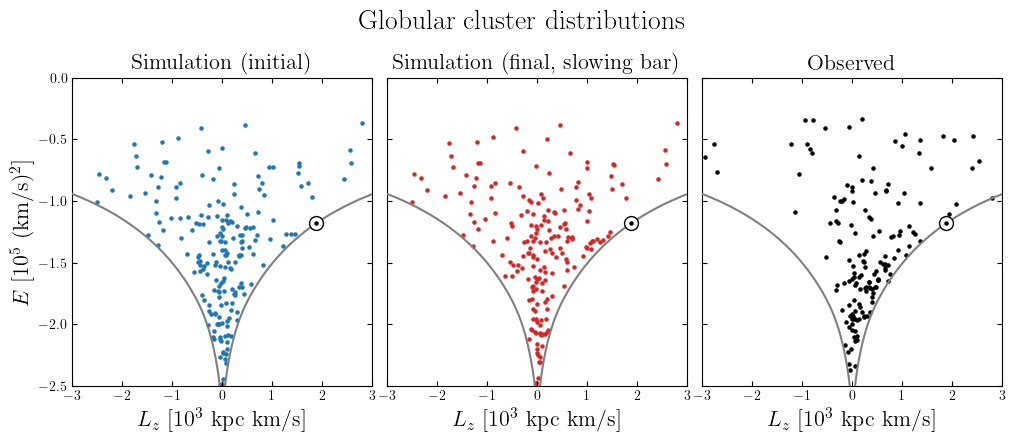

In [21]:
'''Plot E/Lz distributions of mock and real GCs'''

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.05)

print(act_prog_axi.shape)
print(E_prog_axi.shape)

axs[0].scatter(Lz_prog_slow[prog_cut,0]/1e3, E_prog_slow[prog_cut,0]/1e5, s=5, marker='o')

axs[1].scatter(Lz_prog_slow[prog_cut,1]/1e3, E_prog_slow[prog_cut,1]/1e5, s=5, marker='o', c='tab:red')

axs[2].scatter(Lz_GC/1e3, E_GC/1e5, s=5, marker='o', c='k')


# Calculate energy of circular planar orbits
rgrid = np.linspace(0.1, 40, 1000)
vcirc = (-rgrid * pot_axi.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5
Lz_circ = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + pot_axi.potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)

# Calculate energy and angular momentum of circular orbit at Solar radius
r0 = 8.178
vc0 = 229
Lz0 = r0 * vc0
E0 = 0.5 * vc0**2 + pot_axi.potential([r0, 0, 0])

for ax in axs.flat:
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2.5, 0)

    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

    ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)

axs[0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

axs[0].set_title('Simulation (initial)', fontsize=16)
axs[1].set_title('Simulation (final, slowing bar)', fontsize=16)
axs[2].set_title('Observed', fontsize=16)

fig.suptitle('Globular cluster distributions', fontsize=20, y=1.05)

plt.savefig(figpath+'GC_E_Lz.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_70620/1432179059.py:25: SyntaxWarning: invalid escape sequence '\p'
  axs[1,0].set_ylabel('$L_\perp$ [$10^3$ kpc km/s]', fontsize=16)


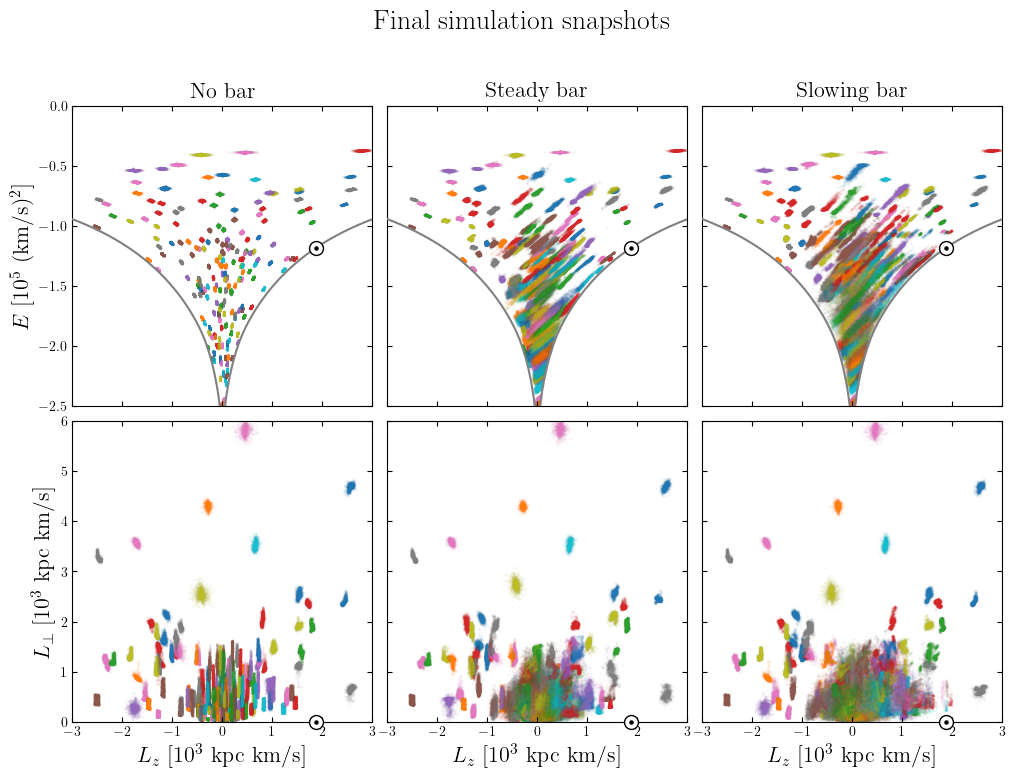

In [25]:
'''Plot energy and angular momentum of all debris'''

fig, axs = plt.subplots(2,3, figsize=(12,8), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(len(trajs_axi_array)):
    if prog_cut[i] == True:
        axs[0,0].scatter(act_axi[i,-1,:,2]/1e3, E_axi[i,-1]/1e5, s=0.1, alpha=0.1)
        axs[0,1].scatter(act_bar[i,-1,:,2]/1e3, E_bar[i,-1]/1e5, s=0.1, alpha=0.1)
        axs[0,2].scatter(act_slow[i,-1,:,2]/1e3, E_slow[i,-1]/1e5, s=0.1, alpha=0.1)

        axs[1,0].scatter(act_axi[i,-1,:,2]/1e3, Lperp_axi[i,-1]/1e3, s=0.1, alpha=0.1)
        axs[1,1].scatter(act_bar[i,-1,:,2]/1e3, Lperp_bar[i,-1]/1e3, s=0.1, alpha=0.1)
        axs[1,2].scatter(act_slow[i,-1,:,2]/1e3, Lperp_slow[i,-1]/1e3, s=0.1, alpha=0.1)

for ax in axs[0].flat:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-2.5, 0)

for ax in axs[1].flat:
    ax.set_ylim(0, 6)
    ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)

axs[0,0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)
axs[1,0].set_ylabel('$L_\perp$ [$10^3$ kpc km/s]', fontsize=16)

axs[0,0].set_title('No bar', fontsize=16)
axs[0,1].set_title('Steady bar', fontsize=16)
axs[0,2].set_title('Slowing bar', fontsize=16)


# r0 = 8.178
# vc0 = 229
# Lz0 = r0 * vc0
# E0 = 0.5 * vc0**2 + pot_axi.potential([r0, 0, 0])


# # Plot piecewise function marking boundary of unaffected orbits
# bound_neg = lambda x: E0/1e5 + 0.2 + x
# bound_pos = lambda x: E0/1e5 + 0.2

# x = np.linspace(-3, 3, 101)

# bound = np.piecewise(x, [x<0, x>=0], [bound_neg, bound_pos])

# Calculate energy of circular planar orbits
rgrid = np.linspace(0.1, 40, 1000)
vcirc = (-rgrid * pot_axi.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5
Lz_circ = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + pot_axi.potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)

for ax in axs[0].flat:
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

for ax in axs[1].flat:
    ax.scatter(Lz0/1e3, 0, marker='o', c='w', edgecolor='k', s=100, zorder=4, clip_on=False)
    ax.scatter(Lz0/1e3, 0, marker='o', c='k', s=5, zorder=4, clip_on=False)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

    ax.set_rasterization_zorder(10)

fig.suptitle('Final simulation snapshots', fontsize=20, y=1)

plt.savefig(figpath+'E_Lz_sim.pdf', bbox_inches='tight', dpi=200)



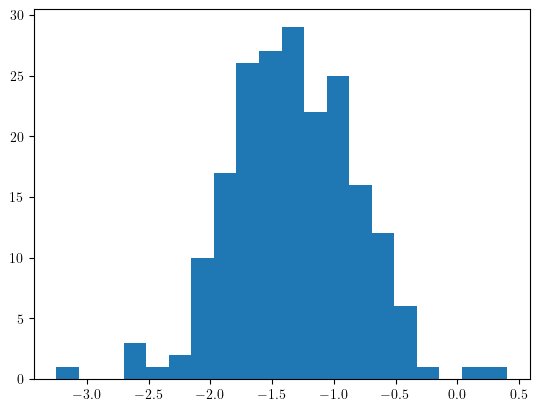

In [33]:
'''Assign metallicities to debris'''

# Progenitor metallicities
FeH_prog = np.random.normal(-1.35, 0.5, len(trajs_axi_array))

# Stellar metallicities
FeH = np.repeat(FeH_prog[:,np.newaxis], trajs_axi_array.shape[2], axis=1)

# Add metallicity spread about progenitor
FeH += np.random.normal(0, 0.04, trajs_axi_array.shape[2])

# Plot histogram
plt.hist(FeH_prog, bins=20)

plt.show()
plt.close()

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_70620/2782935611.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$H_\mathrm{J}$ [$10^5$ (km/s)$^2$]', fontsize=16)


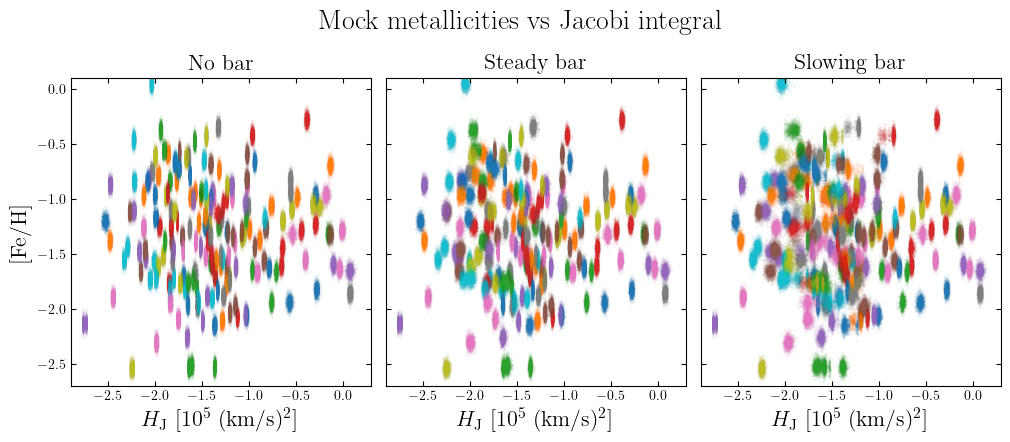

In [34]:
'''Plot metallicity vs Jacobi integral'''

fig, axs = plt.subplots(1,3, figsize=(12,4), sharex='row', sharey='row')
plt.subplots_adjust(wspace=0.05)

for i in range(len(trajs_axi_array)):
    if prog_cut[i] == True:
        axs[0].scatter(HJ_axi[i,-1]/1e5, FeH[i], s=0.1, alpha=0.1)
        axs[1].scatter(HJ_bar[i,-1]/1e5, FeH[i], s=0.1, alpha=0.1)
        axs[2].scatter(HJ_slow[i,-1]/1e5, FeH[i], s=0.1, alpha=0.1)

for ax in axs.flat:
    ax.set_xlim(-2.9, 0.3)
    ax.set_ylim(-2.7, 0.1)
    ax.set_xlabel('$H_\mathrm{J}$ [$10^5$ (km/s)$^2$]', fontsize=16)

axs[0].set_ylabel('[Fe/H]', fontsize=16)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)

axs[0].set_title('No bar', fontsize=16)
axs[1].set_title('Steady bar', fontsize=16)
axs[2].set_title('Slowing bar', fontsize=16)

fig.suptitle('Mock metallicities vs Jacobi integral', fontsize=20, y=1.05)

plt.savefig(figpath+'FeH_HJ.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

Below this point all cells require the 'hires' simulations to be loaded (with 2000 progenitors)

In [28]:
'''Measure gradients of debris and compare to mean Omega_b'''

from scipy.stats import linregress
from matplotlib import cm

slope_bar = np.zeros(len(trajs_axi_array))
slope_slow = np.zeros(len(trajs_axi_array))

for i in range(len(trajs_axi_array)):
    cut = strip_time < 10
    x = act_bar[i,-1,cut,2]
    y = E_bar[i,-1,cut]
    slope_bar[i] = linregress(x, y)[0]

    x = act_slow[i,-1,cut,2]
    y = E_slow[i,-1,cut]
    slope_slow[i] = linregress(x, y)[0]


rgrid = np.linspace(0.1, 40, 1000)
vcirc = (-rgrid * pot_axi.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5
Lz_grid = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + pot_axi.potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)

Lz_circ_bar = np.interp(E_prog_bar[:,-1], E_circ, Lz_grid)
Lz_circ_slow = np.interp(E_prog_slow[:,-1], E_circ, Lz_grid)

eta_bar = Lz_prog_bar[:,-1] / Lz_circ_bar
eta_slow = Lz_prog_slow[:,-1] / Lz_circ_slow


fig, axs = plt.subplots(2, figsize=(4,8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15)


norm = mcolors.Normalize(vmin=-1, vmax=1)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
cmap = cm.seismic
# colors = cmap(norm(values))

axs[0].scatter(E_prog_bar[:,-1]/1e5, slope_bar, s=1, c=eta_bar, cmap=cmap, norm=norm)
axs[1].scatter(E_prog_slow[:,-1]/1e5, slope_slow, s=1, c=eta_slow, cmap=cmap, norm=norm)

cax = axs[0].inset_axes([0.1, 0.9, 0.8, 0.05])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Circularity $\eta$', fontsize=14)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Omega_mean_slow = np.mean(Omega_b[bartime>1])

for ax in axs.flat:
    ax.set_xlim(-2.5, 0)
    ax.set_ylim(-40, 100)
    ax.set_ylabel('$\mathrm{d}E/\mathrm{d}L_z$ [km/s/kpc]', fontsize=16)
    ax.axhline(Omega_b_present, ls='--', c='k', label='Current $\Omega_\mathrm{b}$', zorder=0)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

    ax.set_rasterization_zorder(10)

axs[-1].set_xlabel('$E$ [$10^5$ (km/s$^2$)]', fontsize=16)

axs[1].axhline(Omega_mean_slow, ls='--', c='tab:red', label='Mean $\Omega_\mathrm{b}$', zorder=0)

# axs[1].axhline(Omega_mean_weighted)

# axs[1].axvline(E0/1e5 + 0.2)

axs[1].legend(fontsize=16, loc=1)

axs[0].set_title('Steady bar', fontsize=16)
axs[1].set_title('Slowing bar', fontsize=16)

fig.suptitle('Gradients of debris in $(L_z,E)$ plane', fontsize=18, y=0.98)

# plt.savefig(figpath+'gradients_sim.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\O'
<>:64: SyntaxWarning: invalid escape sequence '\O'
<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\O'
<>:64: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/3466125337.py:47: SyntaxWarning: invalid escape sequence '\e'
  cb.set_label('Circularity $\eta$', fontsize=14)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/3466125337.py:56: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{d}E/\mathrm{d}L_z$ [km/s/kpc]', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/3466125337.py:57: SyntaxWarning: invalid escape sequence '\O'
  ax.axhline(Omega_b_present, ls='--', c='k', label='Current $\Omega_\mathrm{b}$', zorder=

IndexError: boolean index did not match indexed array along dimension 2; dimension is 1600 but corresponding boolean dimension is 160

[45.9304866  45.12947928 45.10103927 43.93791901 43.73842037 44.10807248
 43.04597361 42.62421089 41.14839567 39.20582725 38.77321323 37.33815859
 36.56190496 36.19316295 35.20214714 33.39027049 32.33712083 31.55139752
 27.58585276 27.78536017]
[ 6.31100149  5.58822475  5.56426017  4.57505129  5.38030392  4.5570417
  5.83787998  4.67581466  5.94914044  6.70752459  6.51793984  8.79119338
  7.78674473  8.80689075 14.84251699 13.93401946 10.48203944 20.15389775
 32.17233228 62.23291649]


<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:34: SyntaxWarning: invalid escape sequence '\O'
<>:35: SyntaxWarning: invalid escape sequence '\O'
<>:41: SyntaxWarning: invalid escape sequence '\O'
<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:34: SyntaxWarning: invalid escape sequence '\O'
<>:35: SyntaxWarning: invalid escape sequence '\O'
<>:41: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_84449/1437576431.py:33: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(bartime, Omega_mean, label='Mean $\Omega_\mathrm{b}$', c='tab:red')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_84449/1437576431.py:34: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(bartime, Omega_b, label='$\Omega_\mathrm{b}$', c='tab:blue')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_84449/1437576431.py:35: SyntaxWarning: invalid escape sequence '\O'
  plt.axhline(Omega_b_present, ls='--', c='grey', label='Cur

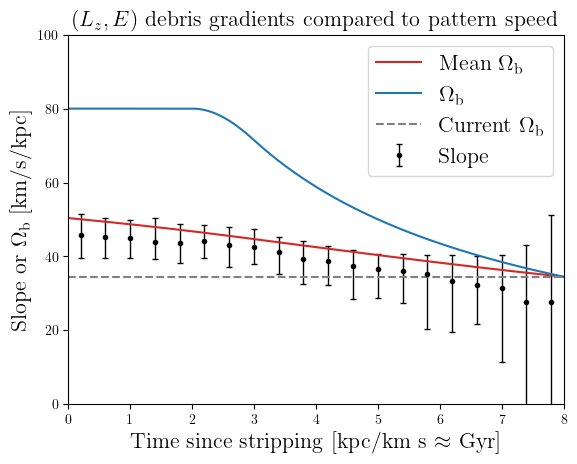

In [ ]:
'''Or plot slope vs strip time, compared to mean Omega [NOT USED IN PAPER]'''

time_bins = np.linspace(0, strip_time[-1], 21)
time_bincentres = 0.5*(time_bins[1:] + time_bins[:-1])

# Omega_mean = phi_b / (bartime - bartime[-1])
# Omega_mean[bartime<t0] = Omega_mean[bartime==t0]

slope_array = np.zeros((len(trajs_axi_array), len(time_bins)-1))

for i in range(len(trajs_axi_array)):
    if np.median(E_slow[i,-1])/1e5 < -1:
        for j in range(len(time_bins)-1):
            cut = (strip_time > time_bins[j])*(strip_time < time_bins[j+1])

            x = act_slow[i,-1,cut,2]
            y = E_slow[i,-1,cut]
            slope = linregress(x, y)[0]

            slope_array[i,j] = slope

slope_array[slope_array==0] = np.nan

slope_median = np.nanmedian(slope_array, axis=0)
slope_16 = np.abs(np.nanpercentile(slope_array, 16, axis=0) - slope_median)
slope_84 = np.abs(np.nanpercentile(slope_array, 84, axis=0) - slope_median)

print(slope_median)
print(slope_16)

plt.errorbar(time_bincentres, slope_median, [slope_16, slope_84], c='k', fmt='.', capsize=2, elinewidth=1, capthick=1, label='Slope')

# plt.plot(bartime, Omega_mean, label='Mean $\Omega_\mathrm{b}$', c='tab:red')
plt.plot(bartime, Omega_b, label='$\Omega_\mathrm{b}$', c='tab:blue')
plt.axhline(Omega_b_present, ls='--', c='grey', label='Current $\Omega_\mathrm{b}$')

plt.xlim(0,8)
plt.ylim(0, 100)

plt.xlabel('Time since stripping [kpc/km s $\\approx$ Gyr]', fontsize=16)
plt.ylabel('Slope or $\Omega_\mathrm{b}$ [km/s/kpc]', fontsize=16)

plt.title('$(L_z,E)$ debris gradients compared to pattern speed', fontsize=16)

plt.legend(fontsize=16)


[4.84623712e+04 1.77525403e-02 5.05053250e+02 5.10408085e-03]


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/721327165.py:31: RuntimeWarning: divide by zero encountered in divide
  result = curve_fit(paraboloid, [x[cut], y[cut]], z[cut], sigma=1/weights[cut]**0.5)


(-2.5, 0.0)

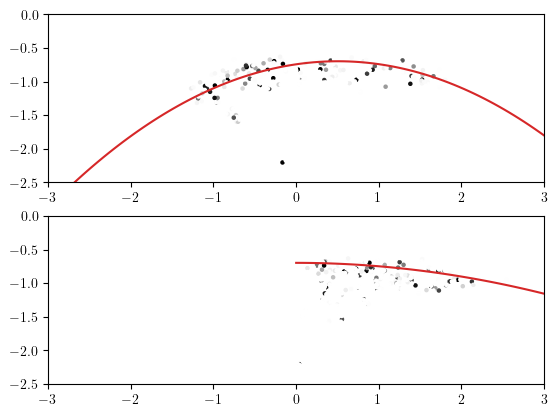

In [34]:
'''Fit paraboloid to surface where dispersion increases by factor of e'''

from scipy.optimize import curve_fit
from matplotlib import cm

def calc_dispersion_ratio(x, y):
    std_x = np.nanstd(x, axis=-1)
    std_y = np.nanstd(y, axis=-1)
    return std_x / std_y

ratio = calc_dispersion_ratio(act_slow[:,-1,:,2], act_axi[:,-1,:,2])

x = Lz_prog_axi[:,-1]
y = Lperp_prog_axi[:,-1]
z = E_prog_axi[:,-1]

cut = (z > -2e5)

threshold = 1
delta = np.log(ratio) - threshold
sigma = 0.1
weights = np.exp(-delta**2 / (2*sigma**2))

# weights = 1/(np.log(ratio/2))**2

def paraboloid(xy, a, b, c, d):
    x = xy[0]
    y = xy[1]
    return E0 + a - b*(x-c)**2 - d*y**2

result = curve_fit(paraboloid, [x[cut], y[cut]], z[cut], sigma=1/weights[cut]**0.5)

print(result[0])

a, b, c, d = result[0]

def Ecrit(Lz, Lperp):
    return E0 + a - b*(Lz-c)**2 - d*Lperp**2

fig, axs = plt.subplots(2)

axs[0].scatter(x/1e3, z/1e5, c=weights, cmap=cm.Greys, vmin=0, vmax=1, s=5)
axs[1].scatter(y/1e3, z/1e5, c=weights, cmap=cm.Greys, vmin=0, vmax=1, s=5)

xgrid = np.linspace(-3, 3, 100)*1e3
curvegrid = E0 + a - b*(xgrid-c)**2

axs[0].plot(xgrid/1e3, curvegrid/1e5, c='tab:red')

ygrid = np.linspace(0, 3, 100)*1e3
curvegrid = E0 + a - d*ygrid**2

axs[1].plot(ygrid/1e3, curvegrid/1e5, c='tab:red')

# plt.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
# plt.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

# plt.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
# plt.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

axs[0].set_xlim(-3,3)
axs[0].set_ylim(-2.5,0)

axs[1].set_xlim(-3,3)
axs[1].set_ylim(-2.5,0)


<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:137: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\p'
<>:165: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\p'
<>:199: SyntaxWarning: invalid escape sequence '\l'
<>:200: SyntaxWarning: invalid escape sequence '\l'
<>:211: SyntaxWarning: invalid escape sequence '\m'
<>:211: SyntaxWarning: invalid escape sequence '\m'
<>:211: SyntaxWarning: invalid escape sequence '\m'
<>:211: SyntaxWarning: invalid escape sequence '\,'
<>:211: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:137: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\p'
<>:165: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\p'
<>:199: Syntax

34.48275862068965


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/3141806542.py:133: RuntimeWarning: invalid value encountered in sqrt
  bound = ((a - b*(x-c)**2)/d)**0.5


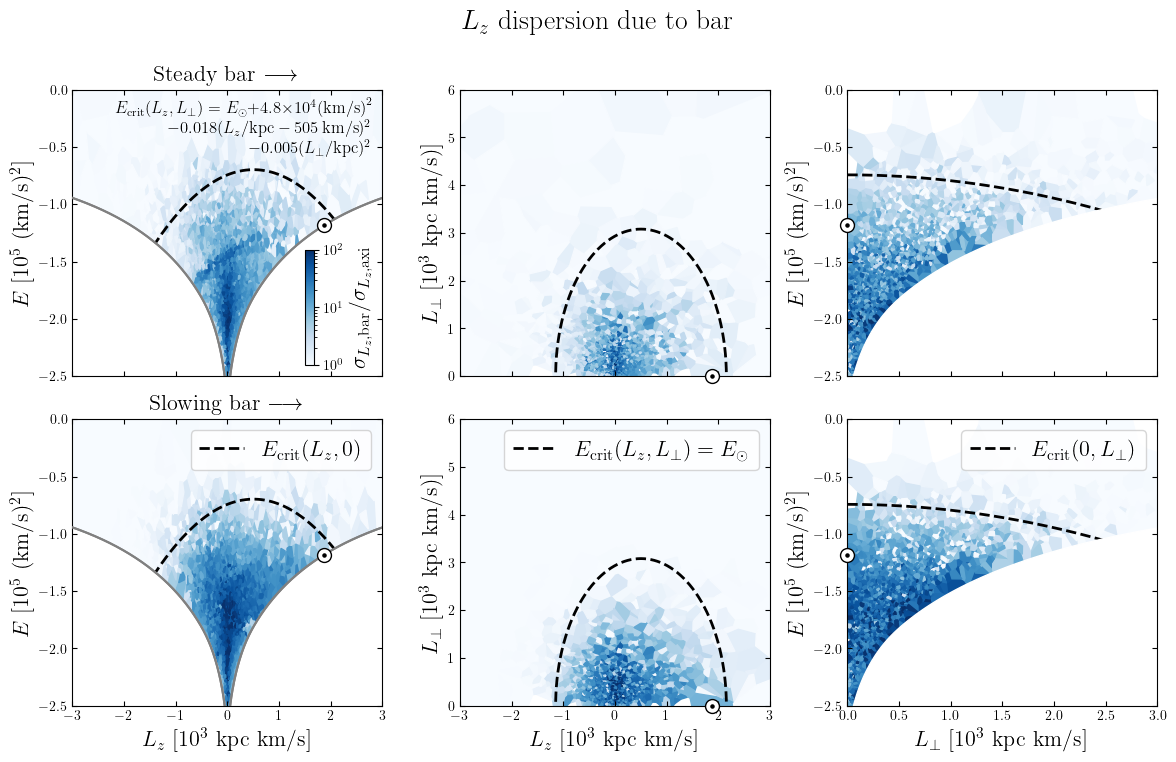

In [35]:
from scipy.spatial import Voronoi, voronoi_plot_2d

print(Omega_b[-1])
# print(E_axi[0,-1]/1e5)

# plt.hist(KLD_slow, bins=np.linspace(0, 20, 11))
# plt.show()
# plt.close()
fig, axs = plt.subplots(2,3, figsize=(14,8), sharex='col', sharey='col')
plt.subplots_adjust(wspace=0.25, hspace=0.15)

cut = ts[-1] - strip_time < 100

# points = np.stack((Lz_prog_axi[:,-1]/1e3, E_prog_axi[:,-1]/1e5)).T
def calc_dispersion_ratio(x, y):
    std_x = np.nanstd(x, axis=-1)
    std_y = np.nanstd(y, axis=-1)
    return std_x / std_y

points_list = [np.stack((Lz_prog_axi[:,-1]/1e3, E_prog_axi[:,-1]/1e5)).T, np.stack((Lz_prog_axi[:,-1]/1e3, Lperp_prog_axi[:,-1]/1e3)).T, np.stack((Lperp_prog_axi[:,-1]/1e3, E_prog_axi[:,-1]/1e5)).T]
values_list = [calc_dispersion_ratio(act_bar[:,-1,:,2], act_axi[:,-1,:,2]), calc_dispersion_ratio(act_slow[:,-1,:,2], act_axi[:,-1,:,2])]

for i in range(len(values_list)):
    for j in range(len(points_list)):
        values = values_list[i]
        points = points_list[j]

        vor = Voronoi(points)

        voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_alpha=0)

        # axs[i,j].scatter(points[:,0], points[:,1], s=5, c='k', zorder=5)

        # norm = mcolors.LogNorm(np.e**-2,np.e**4)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
        # cmap = cm.seismic

        norm = mcolors.LogNorm(1,1e2)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
        cmap = cm.Blues
        colors = cmap(norm(values))
        for k, point in enumerate(points):
            region_index = vor.point_region[k]  # Get the region index for this point
            region = vor.regions[region_index]  # Get the vertices of this region

            if -1 not in region and len(region) > 0:  # Ignore infinite regions
                polygon = [vor.vertices[l] for l in region]
                axs[i,j].fill(*zip(*polygon), color=colors[k], alpha=1, linewidth=1)  # Color based on assigned value

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# cb = fig.colorbar(sm, ax=axs[0,0], alpha=1)
# cb.set_label('$\sigma_{L_z,\mathrm{steady}}/\sigma_{L_z,\mathrm{axi}}$', fontsize=16)

# values = np.nanstd(act_slow[:,-1,:,2], axis=-1) / np.std(act_axi[:,-1,:,2], axis=-1)

# norm = mcolors.LogNorm(1,1e2)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
# cmap = cm.Blues
# colors = cmap(norm(values))
# for i, point in enumerate(points):
#     region_index = vor.point_region[i]  # Get the region index for this point
#     region = vor.regions[region_index]  # Get the vertices of this region

#     if -1 not in region and len(region) > 0:  # Ignore infinite regions
#         polygon = [vor.vertices[j] for j in region]
#         axs[1,0].fill(*zip(*polygon), color=colors[i], alpha=1, linewidth=1)  # Color based on assigned value

cax = axs[0,0].inset_axes([0.75, 0.04, 0.03, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, cax=cax, alpha=1)
cb.set_label('$\sigma_{L_z,\mathrm{bar}}/\sigma_{L_z,\mathrm{axi}}$', fontsize=16)


# flag = E_prog_axi[:,-1] < E0 + 5e4 - 0.03*(Lz_prog_axi[:,-1]-350)**2
# bins = np.logspace(0, 2, 21)

# values = np.nanstd(act_bar[:,-1,:,2], axis=-1) / np.std(act_axi[:,-1,:,2], axis=-1)
# axs[1,0].hist(values[~flag], histtype='step', bins=bins, color='tab:blue', label='$E>E_\mathrm{crit}(L_z)$')
# axs[1,0].hist(values[flag], histtype='step', bins=bins, color='tab:red', label='$E<E_\mathrm{crit}(L_z)$')


# values = np.nanstd(act_slow[:,-1,:,2], axis=-1) / np.std(act_axi[:,-1,:,2], axis=-1)
# axs[1,1].hist(values[~flag], histtype='step', bins=bins, color='tab:blue')
# axs[1,1].hist(values[flag], histtype='step', bins=bins, color='tab:red')


# axs[1,0].legend(fontsize=16)
# axs[1,0].set_ylabel('Count', fontsize=16)

# for ax in axs[1].flat:
#     ax.set_xscale('log')
#     ax.set_xlim(1e0,1e2)

#     ax.set_xlabel('$\sigma_{L_z,\mathrm{bar}}/\sigma_{L_z,\mathrm{axi}}$', fontsize=16)
# ax.scatter(Lz_prog_axi[:,-1]/1e3, E_prog_axi[:,-1]/1e5, c=colors, zorder=5, s=5)#norm=mcolors.CenteredNorm(vcenter=2, halfrange=8), cmap='seismic')

# axs[2].scatter(Lz_GC/1e3, E_GC/1e5, c='tab:blue', s=5)
# axs[2].scatter(Lz_stream/1e3, E_stream/1e5, c='tab:red', s=5)


r0 = 8.178
vc0 = 229
Lz0 = r0 * vc0
E0 = 0.5 * vc0**2 + pot_axi.potential([r0, 0, 0])

# Plot function marking boundary of unaffected orbits
x = np.linspace(-3000, 3000, 101)
bound = E0 + a - b*(x-c)**2
# bound = E0 + 5e4 - 0.03*(x-500)**2

for ax in axs[:,0].flat:
    ax.plot(x/1e3, bound/1e5, ls='--', c='k', zorder=1, lw=2, label='$E_\mathrm{crit}(L_z,0)$')

    ax.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)
    ax.fill_between(-Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.set_xlim(-3,3)
    ax.set_ylim(-2.5, 0)

    ax.set_rasterization_zorder(10)

    ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)


# Plot function marking boundary of unaffected orbits
x = np.linspace(-3000, 3000, 10001)
bound = ((a - b*(x-c)**2)/d)**0.5
# bound = ((5e4 - 0.03*(x-400)**2)/0.01)**0.5

for ax in axs[:,1].flat:
    ax.plot(x/1e3, bound/1e3, ls='--', c='k', zorder=1, lw=2, label='$E_\mathrm{crit}(L_z,L_\perp)=E_\odot$')

    # ax.fill_between(Lz_circ/1e3, -5, 0, color='w', zorder=1)
    # ax.fill_between(-Lz_circ/1e3, -5, 0, color='w', zorder=1)

    # ax.plot(Lz_circ/1e3, 0, c='grey', zorder=3)
    # ax.plot(-Lz_circ/1e3, 0, c='grey', zorder=3)

    ax.scatter(Lz0/1e3, 0, marker='o', c='w', edgecolor='k', s=100, zorder=4, clip_on=False)
    ax.scatter(Lz0/1e3, 0, marker='o', c='k', s=5, zorder=4, clip_on=False)

    # ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    # ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.set_xlim(-3,3)
    ax.set_ylim(0,6)

    ax.set_rasterization_zorder(10)

    ax.set_ylabel('$L_\perp$ [$10^3$ kpc km/s)]', fontsize=16)


# Plot function marking boundary of unaffected orbits
x = np.linspace(0, 3000, 1001)
bound = E0 + a - b*(0-c)**2 - d*x**2
# bound = E0 + 5e4 - 0.01*(x-0)**2

for ax in axs[:,2].flat:
    ax.plot(x/1e3, bound/1e5, ls='--', c='k', zorder=1, lw=2, label='$E_\mathrm{crit}(0,L_\perp)$')

    ax.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)
    # ax.fill_between(-Lz_circ/1e3, -5, 0, color='w', zorder=1)

    # ax.plot(Lz_circ/1e3, 0, c='grey', zorder=3)
    # ax.plot(-Lz_circ/1e3, 0, c='grey', zorder=3)

    ax.scatter(0, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4, clip_on=False)
    ax.scatter(0, E0/1e5, marker='o', c='k', s=5, zorder=4, clip_on=False)

    # ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    # ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.set_xlim(0,3)
    ax.set_ylim(-2.5,0)

    ax.set_rasterization_zorder(10)

    ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)


axs[1,0].set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
axs[1,1].set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
axs[1,2].set_xlabel('$L_\perp$ [$10^3$ kpc km/s]', fontsize=16)

for ax in axs[1].flat:
    ax.legend(fontsize=16, loc=1)

for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in', which='both')

axs[0,0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

axs[0,0].set_title('Steady bar $\longrightarrow$', fontsize=16)
axs[1,0].set_title('Slowing bar $\longrightarrow$', fontsize=16)

# axs[1,0].set_title('Steady bar', fontsize=16)
# axs[1,1].set_title('Slowing bar', fontsize=16)

a_round = np.round(a/1e4, 1)
b_round = np.round(b, 3)
c_round = int(c)
d_round = np.round(d, 3)


text = ('$E_\mathrm{crit}(L_z,L_\perp) = E_\odot + $'+str(a_round)+'$\\times10^4\mathrm{(km/s)}^2$\n$-'+str(b_round)+'(L_z/\mathrm{kpc} - '+str(c_round)+'\,\mathrm{km/s})^2$\n$-'+str(d_round)+'(L_\perp/\mathrm{kpc})^2$')

axs[0,0].text(2.8, -0.55, text, fontsize=12, ha='right')

fig.suptitle('$L_z$ dispersion due to bar', fontsize=20)

# plt.savefig(figpath+'Lz_dispersion_sim.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

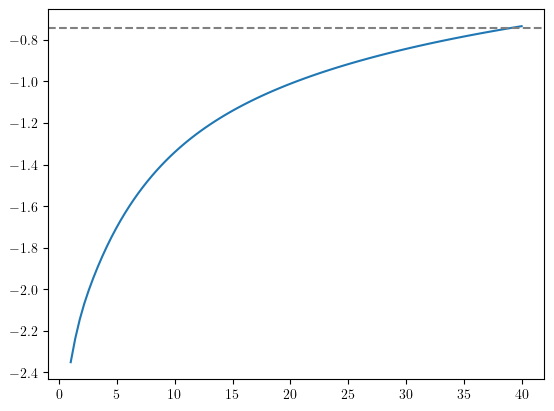

In [139]:
'''Plot potential to find largest radius of influence'''

rgrid = np.linspace(1, 40, 101)

y = pot_axi.potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)/1e5

plt.plot(rgrid, y)

# plt.axhline(0, ls='--', c='grey')

plt.axhline(Ecrit(0,0)/1e5, ls='--', c='grey')

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_2168/1684880443.py:7: SyntaxWarning: invalid escape sequence '\m'
  axs[0].hist(values[~flag], histtype='step', bins=bins, color='tab:blue', label='$E>E_\mathrm{crit}(L_z,L_\perp)$')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_2168/1684880443.py:8: SyntaxWarning: invalid escape sequence '\m'
  axs[0].hist(values[flag], histtype='step', bins=bins, color='tab:red', label='$E<E_\mathrm{crit}(L_z,L_\perp)$')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_2168/1684880443.py:28: SyntaxWarning: invalid escape sequence '\s'
  axs[-1].set_xlabel('$\sigma_{L_z,\mathrm{bar}}/\sigma_{L_z,\mathrm{axi}}$', fontsize=16)

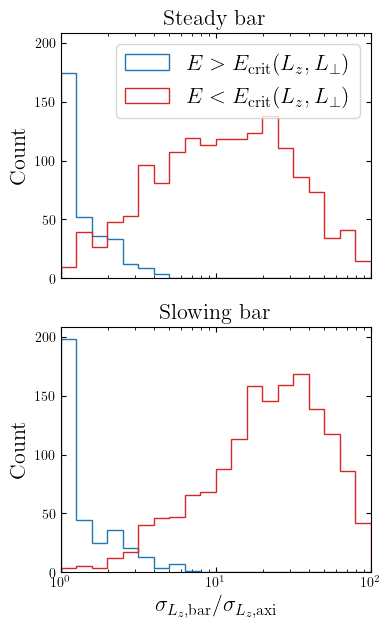

In [ ]:
'''Plot histograms of structures above and below critical boundary'''

fig, axs = plt.subplots(2, figsize=(4,7), sharex=True, sharey=True)

flag = E_prog_axi[:,-1] < Ecrit(Lz_prog_axi[:,-1], Lperp_prog_axi[:,-1])
bins = np.logspace(0, 2, 21)

values = np.nanstd(act_bar[:,-1,:,2], axis=-1) / np.std(act_axi[:,-1,:,2], axis=-1)
axs[0].hist(values[~flag], histtype='step', bins=bins, color='tab:blue', label='$E>E_\mathrm{crit}(L_z,L_\perp)$')
axs[0].hist(values[flag], histtype='step', bins=bins, color='tab:red', label='$E<E_\mathrm{crit}(L_z,L_\perp)$')


values = np.nanstd(act_slow[:,-1,:,2], axis=-1) / np.std(act_axi[:,-1,:,2], axis=-1)
axs[1].hist(values[~flag], histtype='step', bins=bins, color='tab:blue')
axs[1].hist(values[flag], histtype='step', bins=bins, color='tab:red')


axs[0].legend(fontsize=16)


for ax in axs.flat:
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in', which='both')
    ax.set_xscale('log')
    ax.set_xlim(1e0,1e2)
    ax.set_ylabel('Count', fontsize=16)

axs[0].set_title('Steady bar', fontsize=16)
axs[1].set_title('Slowing bar', fontsize=16)

axs[-1].set_xlabel('$\sigma_{L_z,\mathrm{bar}}/\sigma_{L_z,\mathrm{axi}}$', fontsize=16)

plt.savefig(figpath+'boundary_test.pdf', bbox_inches='tight', dpi=200)
# ax.scatter(Lz_prog_axi[:,-1]/1e3, E_prog_axi[:,-1]/1e5, c=colors, zorder=5, s=5)#norm=mcolors.CenteredNorm(vcenter=2, halfrange=8), cmap='seismic')

# axs[2].scatter(Lz_GC/1e3, E_GC/1e5, c='tab:blue', s=5)
# axs[2].scatter(Lz_stream/1e3, E_stream/1e5, c='tab:red', s=5)

0.11597897484131768


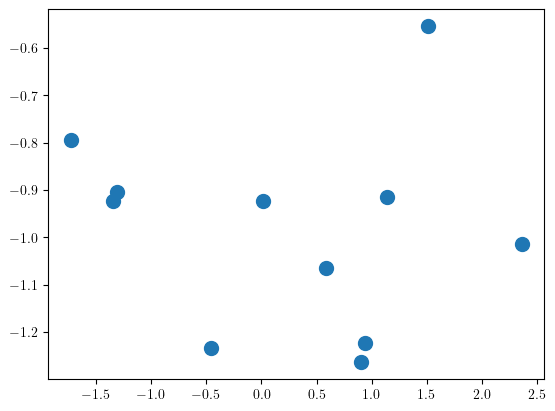

In [ ]:
'''Load Naidu substructure data'''

substructure = np.loadtxt(datapath+'substructure_naidu.txt', skiprows=2, dtype=str)

# Unit conversions and potential shift
pot_PW19 = agama.Potential(agama_pot_path+'PriceWhelan19.ini')

E_shift = pot_axi.potential([8,0,0]) - pot_PW19.potential([8,0,0])

print(E_shift/1e5)

L_conversion = -1e3
E_conversion = 1e5

Lz_sub = substructure[:,10].astype(float) * L_conversion
E_sub = substructure[:,9].astype(float) * E_conversion + E_shift

plt.scatter(Lz_sub/1e3, E_sub/1e5, s=100)


In [37]:
'''Load Andrae RGB sample'''

from astropy.io import fits
from astropy.table import Table

hdu_RGB = fits.open(datapath+'table_2_catwise.fits', memmap=True)
t_RGB = Table.read(hdu_RGB)

'''Transform and cut RGB sample data'''

coords_RGB = coord.SkyCoord(ra=t_RGB['ra']*u.deg, dec=t_RGB['dec']*u.deg, distance=1/t_RGB['parallax']*u.kpc, pm_ra_cosdec=t_RGB['pmra']*u.mas/u.yr, pm_dec=t_RGB['pmdec']*u.mas/u.yr, radial_velocity=t_RGB['radial_velocity']*u.km/u.s)

coords_RGB = coords_RGB.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic_RGB = np.array([coords_RGB.x.value, coords_RGB.y.value, coords_RGB.z.value, coords_RGB.v_x.value, coords_RGB.v_y.value, coords_RGB.v_z.value]).T

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic_RGB = ic_RGB*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn_RGB = t_RGB['parallax']/t_RGB['parallax_error']
dist_RGB = 1/t_RGB['parallax']
MH_RGB = t_RGB['mh_xgboost']
# logg = t_RGB['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn_RGB > parsn_min) * (dist_RGB < dist_max)

dist_RGB = dist_RGB[cut]
ic_RGB = ic_RGB[cut]
MH_RGB = MH_RGB[cut]

# ra_RGB = t_RGB['ra'][cut]
# dec_RGB = t_RGB['dec'][cut]

# R_RGB = np.linalg.norm(ic_RGB[:,0:2], axis=1)
# phi_RGB_sun = np.arctan2(ic_RGB[:,1], ic_RGB[:,0])
# z_RGB = ic_RGB[:,2]

# R_hat = ic_RGB[:,0:3] * [1, 1, 0] / R_RGB[:,None]
# vR_RGB = (ic_RGB[:,3:6] * R_hat).sum(axis=1)
# phi_hat = np.cross([0,0,1], R_hat)
# vphi_RGB = (ic_RGB[:,3:6] * phi_hat).sum(axis=1)
L_RGB = np.cross(ic_RGB[:,0:3], ic_RGB[:,3:6])

Lz_RGB = L_RGB[:,2]
Lperp_RGB = np.linalg.norm(L_RGB[:,0:2], axis=1)
E_RGB = 0.5 * (ic_RGB[:,3:6]**2).sum(axis=-1) + pot_bar_Hunter_rot.potential(ic_RGB[:,0:3])

In [ ]:
'''Assign ellipse sizes and angles to Naidu substructures (roughly reproduces RH panel of Naidu+2020)'''

widths = np.array([1, 2, 1.5, 1, 0.5, 2, 0.5, 0.5, 1, 1, 0.5])
heights = np.array([1, 0.5, 0.3, 0.1, 0.3, 0.1, 0.5, 0.5, 0.5, 0.1, 0.2])
angles = np.array([0, 0, 10, -20, 0, 10, 0, 0, -20, -20, -20])


['Gaia-Sausage-Enceladus' 'Sagittarius' 'High-alpha_Disk_+_In_Situ_Halo'
 'Arjuna' 'Metal-weak_Thick_Disk' 'Aleph' 'Wukong' 'Helmi_Streams'
 'Sequoia' "I'itoi" 'Thamnos']


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/718822003.py:9: SyntaxWarning: invalid escape sequence '\m'
  axs[0].scatter(Lz_GC[~flag_GC]/1e3, E_GC[~flag_GC]/1e5, c='tab:blue', s=10, marker='o', label='$E>E_\mathrm{crit}$')
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/718822003.py:10: SyntaxWarning: invalid escape sequence '\m'
  axs[0].scatter(Lz_GC[flag_GC]/1e3, E_GC[flag_GC]/1e5, c='tab:red', s=10, marker='o', label='$E<E_\mathrm{crit}$')
/var/f

0.7235294117647059
0.2441860465116279
0.9499568360850329
   name  
---------
   NGC288
   Hydrus
  NGC1851
    New-6
    New-9
      C-9
   New-15
   Gaia-7
   Gaia-8
   New-17
    LMS-1
   New-19
     Pal5
       M5
     Svol
Ophiuchus
      M92
  NGC6397
     Hrid
  NGC7099
   New-27


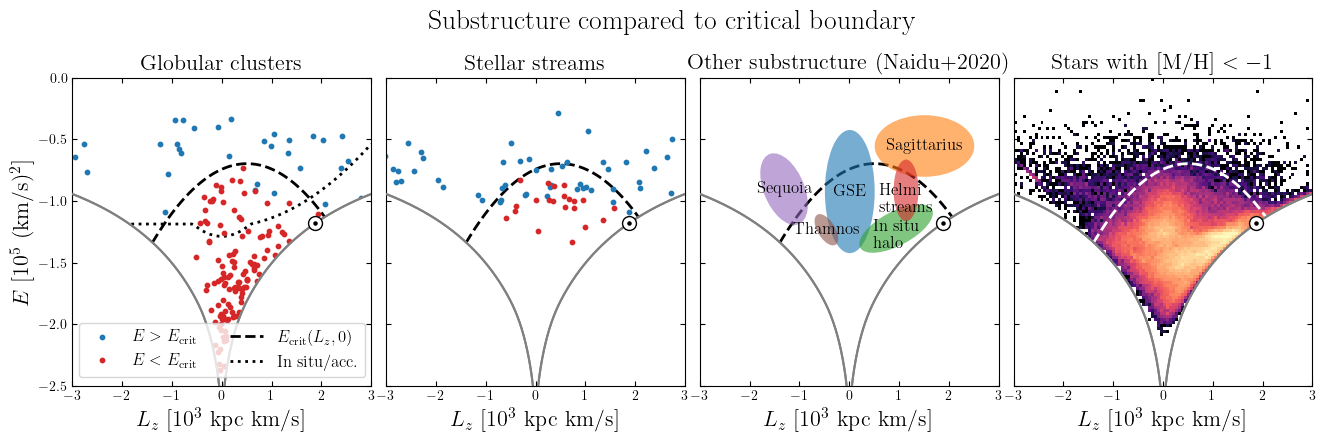

In [ ]:
from matplotlib.patches import Ellipse

fig, axs = plt.subplots(1,4, figsize=(16,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

flag_GC = E_GC < Ecrit(Lz_GC, Lperp_GC)
flag_stream = E_stream < Ecrit(Lz_stream, Lperp_stream)

axs[0].scatter(Lz_GC[~flag_GC]/1e3, E_GC[~flag_GC]/1e5, c='tab:blue', s=10, marker='o', label='$E>E_\mathrm{crit}$')
axs[0].scatter(Lz_GC[flag_GC]/1e3, E_GC[flag_GC]/1e5, c='tab:red', s=10, marker='o', label='$E<E_\mathrm{crit}$')

axs[1].scatter(Lz_stream[~flag_stream]/1e3, E_stream[~flag_stream]/1e5, c='tab:blue', s=10, marker='o', label='$E>E_\mathrm{crit}$')
axs[1].scatter(Lz_stream[flag_stream]/1e3, E_stream[flag_stream]/1e5, c='tab:red', s=10, marker='o', label='$E<E_\mathrm{crit}$')

cmap = plt.get_cmap('tab10')

# Get the list of 10 RGB colors
colors = [cmap(i) for i in range(cmap.N)]

color_count = 0
for i in range(len(Lz_sub)):
    label_offset = 0
    name = list(substructure[i,0])
    for j in range(len(name)):
        if name[j] == '_':
            name[j] = ' '
    name = ''.join(name)

    if name == 'Gaia-Sausage-Enceladus':
        name = 'GSE'
    
    if name == 'High-alpha Disk + In Situ Halo':
        name = 'In situ\nhalo'
        label_offset = -0.05
    
    if name == 'Helmi Streams':
        name = 'Helmi\nstreams'
        label_offset = -0.07


    names_ignore = ["I'itoi", "Metal-weak Thick Disk", "Arjuna", 'Aleph', 'Wukong']

    if ~np.isin(name, names_ignore):
        ellipse = Ellipse((Lz_sub[i]/1e3, E_sub[i]/1e5), width=widths[i], height=heights[i], angle=angles[i], alpha=0.6, facecolor=colors[color_count%10], label=name)
        axs[2].add_patch(ellipse)
        axs[2].text(Lz_sub[i]/1e3, E_sub[i]/1e5+label_offset, name, ha='center', va='center', ma='left', fontsize=12)
        color_count += 1
        # axs[2].scatter(Lz_sub[i]/1e3, E_sub[i]/1e5, s=100, label=name, marker='o')
    # offset = [0.05, 0.05]
    # axs[2].text(Lz_sub[i]/1e3+offset[0], E_sub[i]/1e5+offset[1], name, fontsize=12)


# # Plot each ellipse
# for label, x, y, w, h, angle in components:
#     ellipse = Ellipse((-x, y), width=w, height=h, angle=-angle, alpha=0.6)
#     axs[2].add_patch(ellipse)
#     # axs[2].text(x, y, label, ha='center', va='center', fontsize=9, weight='bold')


cut_RGB = (MH_RGB < -1)*~np.isnan(E_RGB)
axs[3].hist2d(Lz_RGB[cut_RGB]/1e3, E_RGB[cut_RGB]/1e5, bins=(np.linspace(-3, 3, 101), np.linspace(-2.5, 0, 101)), cmap='magma', norm=mcolors.LogNorm())

x = np.linspace(-3000, 3000, 101)
bound = Ecrit(x, 0*x)

for ax in axs.flat:
    if ax == axs[3]:
        zorder = 1
        color = 'w'

    # elif ax == axs[2]:
    #     zorder = 1
    #     color = 'k'

    else:
        zorder = 0
        color = 'k'

    if ax == axs[0]:
        label = '$E_\mathrm{crit}(L_z,0)$'
    
    else:
        label = None
    
    ax.plot(x/1e3, bound/1e5, ls='--', c=color, zorder=zorder, lw=2, label=label)

    ax.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)
    ax.fill_between(-Lz_circ/1e3, -5, E_circ/1e5, color='w', zorder=1)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
    ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

    ax.plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    ax.plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

    ax.set_xlim(-3,3)
    ax.set_ylim(-2.5, 0)

    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_rasterization_zorder(10)

    ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)

axs[0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

# Plot boundary between insitu and accreted
insitu_bound = np.piecewise(x, [x<-0.58e3, (x>=-0.58e3)*(x<0.58e3), x>=0.58e3], [-1.3, lambda x: -1.4+0.3*(x/1e3)**2, lambda x: -1.325+0.075*(x/1e3)**2])

pot_Belokurov = agama.Potential(agama_pot_path+'MWPotential2014_mod.ini')
E_shift = pot_axi.potential([8, 0, 0]) - pot_Belokurov.potential([8, 0, 0])

insitu_bound = insitu_bound + E_shift/1e5

axs[0].plot(x/1e3, insitu_bound, c='k', ls=':', lw=2, zorder=0, label='In situ/acc.')

axs[0].legend(ncols=2, loc=8, fontsize=12)#, columnspacing=0.2)


axs[0].set_title('Globular clusters', fontsize=16)
axs[1].set_title('Stellar streams', fontsize=16)
axs[2].set_title('Other substructure (Naidu+2020)', fontsize=16)
axs[3].set_title('Stars with [M/H] $< -1$', fontsize=16)


fig.suptitle('Substructure compared to critical boundary', fontsize=20, y=1.05)

# plt.savefig(figpath+'substructure_boundary.pdf', bbox_inches='tight', dpi=200)


In [ ]:
'''Print table with streams predicted to be affected'''

def arrays_to_latex_table(col1, col2, col1_name="Column 1", col2_name="Column 2"):
    if len(col1) != len(col2):
        raise ValueError("Arrays must have the same length")

    lines = []
    lines.append(r"\begin{tabular}{ll}")
    lines.append(r"\hline")
    lines.append(f"{col1_name} & {col2_name} \\\\")
    lines.append(r"\hline")

    for a, b in zip(col1, col2):
        lines.append(f"{a} & {b} \\\\")

    lines.append(r"\hline")
    lines.append(r"\end{tabular}")

    return "\n".join(lines)


E_minus_E_crit = E_stream - Ecrit(Lz_stream, Lperp_stream)

flag_stream = E_minus_E_crit < 0

order = np.argsort(E_minus_E_crit[flag_stream])

table = arrays_to_latex_table(name_stream[flag_stream][order], np.round(abs(E_minus_E_crit[flag_stream][order]/1e5),2), 'Stream', '$|E-E_\mathrm{crit}(L_z,L_\perp)|$ [$10^5$ (km/s)$^2$]')

print(table)



\begin{tabular}{ll}
\hline
Stream & $|E-E_\mathrm{crit}(L_z,L_\perp)|$ [$10^5$ (km/s)$^2$] \\
\hline
New-15 & 0.63 \\
New-6 & 0.48 \\
New-9 & 0.47 \\
Gaia-7 & 0.3 \\
Hydrus & 0.23 \\
NGC288 & 0.2 \\
NGC6397 & 0.2 \\
NGC1851 & 0.16 \\
Svol & 0.16 \\
C-9 & 0.16 \\
New-27 & 0.14 \\
NGC7099 & 0.13 \\
Pal5 & 0.11 \\
M5 & 0.1 \\
Ophiuchus & 0.08 \\
Gaia-8 & 0.06 \\
New-17 & 0.05 \\
New-19 & 0.04 \\
LMS-1 & 0.04 \\
M92 & 0.03 \\
Hrid & 0.01 \\
\hline
\end{tabular}


<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_29809/898266442.py:28: SyntaxWarning: invalid escape sequence '\m'
  table = arrays_to_latex_table(name_stream[flag_stream][order], np.round(abs(E_minus_E_crit[flag_stream][order]/1e5),2), 'Stream', '$|E-E_\mathrm{crit}(L_z,L_\perp)|$ [$10^5$ (km/s)$^2$]')
